In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Resizing
from tensorflow.keras.layers import Rescaling
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from scipy import ndimage
import cv2

In [2]:
# preprocessing
"""
def SoftenNoise(arrayOfPics):
    x,y,z = arrayOfPics.shape
    c = copy.deepcopy(arrayOfPics)
    c = np.float32(c)
    for i in range(x):
        c[i] = cv2.medianBlur(c[i],3)
    return c
"""
def SoftenNoise(arrayOfPics):
    x,y,z = arrayOfPics.shape
    c = copy.deepcopy(arrayOfPics)
    for i in range(x):
        c[i] = ndimage.gaussian_filter(c[i], 0.69)
    return c
def Normalize(arrayOfPics):
    x,y,z = arrayOfPics.shape
    c = copy.deepcopy(arrayOfPics)
    for i in range(x):
        for j in range(y):
            for k in range(z):
                if c[i][j][k] > 255:
                    c[i][j][k] = 1.0 
                else:
                    raw = c[i][j][k]
                    c[i][j][k] = raw/255
    return c

def process_img(arrayOfPics):
    arrayOfPics = SoftenNoise(arrayOfPics)
    arrayOfPics = Normalize(arrayOfPics)
    return arrayOfPics


In [3]:
"""
with open("/content/drive/MyDrive/551A3/images_l.pkl", 'rb') as f:
  training_data = pickle.load(f)
with open("/content/drive/MyDrive/551A3/labels_l.pkl", 'rb') as f:
  training_label = pickle.load(f)
"""
# load labeled data
with open("images_l.pkl", 'rb') as f:
  training_data = pickle.load(f)
with open("labels_l.pkl", 'rb') as f:
  training_label = pickle.load(f)


In [4]:
# one-hot encoding for labels
all_class = {}
def encode(x):
    where1s = np.where(x == 1)
    # print(where1s[0][0])
    index = where1s[0][0] * 26 + (where1s[0][1] - 10)
    result = np.zeros(260, dtype=np.int_)
    result[index] = 1
    if index not in all_class:
        all_class[index] = result
    return result

def decode(x):
    where1s = np.where(x == 1)
    # print(where1s[0][0])
    index1 = (where1s[0][0]) // 26
    index2 = (where1s[0][0]) % 26  + 10
    result = np.zeros(36)
    result[index1] = 1
    result[index2] = 1
    return result

def process_label(arrayOfLabels):
    l = []
    x = arrayOfLabels.shape[0]
    for i in range(x):
        l.append(encode(arrayOfLabels[i]))
    return np.array(l)

training_label = process_label(training_label)

In [9]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes, finalAct="sigmoid"):
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		# CONV 32 => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))
		# (CONV 64 => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# (CONV 128 => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
  		# (CONV 256 => RELU) * 2 => POOL
		model.add(Conv2D(256, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(256, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
    	# (CONV 512 => RELU) * 2 => POOL
		model.add(Conv2D(512, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(512, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
  		#  FC 4096 => ReLU
		model.add(Flatten())
		model.add(Dense(4096))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
    	#  FC 1024 => ReLU
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# to 260
		model.add(Dense(classes))
		model.add(Activation(finalAct))
		return model


In [10]:
# step 1: train a model with labeled data

#training_data = process_img(training_data)
training_data_step1 = training_data.reshape(-1,56,56,1)
training_label_step1 = copy.deepcopy(training_label)

In [11]:
EPOCHS = 150
LR = 5e-4
BATCH_SIZE = 16
IMAGE_DIMS = (56, 56, 1)
model_1=SmallerVGGNet.build(width=56,height=56,depth=1,classes=260)
opt = Adam(lr=LR, decay=LR / (2*EPOCHS))
model_1.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [12]:
H1 = model_1.fit(x=training_data_step1, y=training_label_step1, epochs=EPOCHS, validation_split=0.2, batch_size=BATCH_SIZE)


Epoch 1/150
1500/1500 [==============================] - 19s 12ms/step - loss: 0.1297 - accuracy: 0.0133 - val_loss: 0.0258 - val_accuracy: 0.0087
Epoch 2/150
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0236 - accuracy: 0.0234 - val_loss: 0.0247 - val_accuracy: 0.0165
Epoch 3/150
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0224 - accuracy: 0.0286 - val_loss: 0.0233 - val_accuracy: 0.0162
Epoch 4/150
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0215 - accuracy: 0.0316 - val_loss: 0.0240 - val_accuracy: 0.0190
Epoch 5/150
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0208 - accuracy: 0.0344 - val_loss: 0.0186 - val_accuracy: 0.0403
Epoch 6/150
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0200 - accuracy: 0.0390 - val_loss: 0.0212 - val_accuracy: 0.0392
Epoch 7/150
1500/1500 [==============================] - 18s 12ms/step - loss: 0.0193 - accuracy: 0.0469 - val_loss: 0

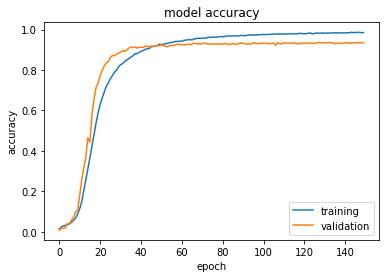

In [13]:
plt.close('all')
plt.plot(H1.history['accuracy'])
plt.plot(H1.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training','validation'], loc='lower right')
plt.savefig('accuracy_step1') 
plt.show()


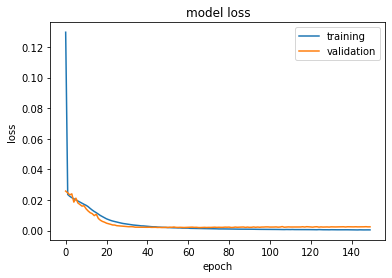

In [14]:
plt.close('all')
plt.plot(H1.history['loss'])
plt.plot(H1.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.savefig('loss_step1')
plt.show()

In [15]:
model_1.save("step1")

INFO:tensorflow:Assets written to: step1/assets


In [16]:
with open("images_test.pkl", 'rb') as f:
    test_data = pickle.load(f)
#test_data = process_img(test_data)
test_data = test_data.reshape(-1,56,56,1)

In [18]:
predictions1 = model_1.predict(test_data)

In [19]:
import pandas as pd
prediction = []

def decode(x):
    where1s = x.argmax()
    # print(where1s[0][0])
    index1 = where1s // 26
    index2 = where1s % 26  + 10
    result = np.zeros(36)
    result[index1] = 1
    result[index2] = 1
    return result,index1,index2
for data in predictions1:
    decoded_pred,index1,index2 = decode(data)
    prediction.append(''.join(["0" if i != index1 and i != index2 else "1" for i in range(36)]))


In [20]:
result = {"# Id": np.arange(15000), 'Category': prediction}
df = pd.DataFrame(data=result, columns=['# Id', 'Category'])
df.to_csv('results_1126_step1_1.csv', header=True, index=False)

In [21]:
# '''
# '''
from tensorflow import keras
pre_model = keras.models.load_model("step1")
# '''
with open("images_ul.pkl", 'rb') as f:
    unlabeled_data = pickle.load(f)

#unlabeled_data_1 = process_img(unlabeled_data)
unlabeled_data_1 = unlabeled_data.reshape(-1,56,56,1)


unlabeled_labels = pre_model.predict(unlabeled_data_1)
unlabeled_labels = (unlabeled_labels == unlabeled_labels.max(axis=1, keepdims=1)).astype(int)
print(unlabeled_labels[0])
# '''

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [22]:

# training_data = np.concatenate((training_data[:24000], unlabeled_data), axis=0)
validation_data = np.copy(training_data[24000:30000])
print(validation_data.shape)

validation_label = np.copy(training_label[24000:30000])
training_data_step2 = np.concatenate((training_data[:24000], unlabeled_data), axis=0)
training_label_step2 = np.concatenate((training_label[:24000], unlabeled_labels), axis=0)
# training_data = np.copy(training_data[:24000])
# training_label = np.copy(training_label[:24000])
#training_data = process_img(training_data)


#validation_data = process_img(validation_data)
#training_data=training_data.reshape(-1,56,56,1)
training_data_step2 = training_data_step2.reshape(-1,56,56,1)
validation_data = validation_data.reshape(-1,56,56,1)

(6000, 56, 56)


In [23]:
print(training_data_step2.shape)
print(validation_data.shape)

(54000, 56, 56, 1)
(6000, 56, 56, 1)


In [ ]:
#training_set = tf.data.Dataset.from_tensor_slices((training_data, training_label))
#print(training_data[1])
#print(training_label[1])
validation_set = tf.data.Dataset.from_tensor_slices((validation_data, validation_label))
#print(validation_label[1])

In [ ]:
IMG_SIZE = 56

resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./ training_data.max())
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomRotation(0.2),
])

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [24]:
EPOCHS = 100
LR = 5e-4
BATCH_SIZE = 16
IMAGE_DIMS = (56, 56, 1)


In [25]:
model_2=SmallerVGGNet.build(width=56,height=56,depth=1,classes=260)
opt = Adam(lr=LR, decay=LR /(2* EPOCHS))
model_2.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [27]:
#training_data = training_data.reshape(-1, 56, 56, 1)
#validation_data = validation_data.reshape(-1, 56, 56, 1)

# H = model.fit(x=training_data,y=training_label,epochs=EPOCHS,validation_split=0.2,batch_size=BATCH_SIZE)
H2 = model_2.fit(x=training_data_step2, y=training_label_step2,epochs=EPOCHS,validation_data=(validation_data,validation_label),batch_size=BATCH_SIZE)
'''
H = model.fit(datagen.flow(training_data, training_label, batch_size=BATCH_SIZE,
         subset='training'),
         validation_data=datagen.flow(training_data, training_label,
         batch_size=BATCH_SIZE, subset='validation'), epochs=EPOCHS)
'''

Epoch 1/100
3375/3375 [==============================] - 40s 11ms/step - loss: 0.0709 - accuracy: 0.0169 - val_loss: 0.0272 - val_accuracy: 0.0153
Epoch 2/100
3375/3375 [==============================] - 38s 11ms/step - loss: 0.0218 - accuracy: 0.0315 - val_loss: 0.0222 - val_accuracy: 0.0330
Epoch 3/100
3375/3375 [==============================] - 39s 11ms/step - loss: 0.0197 - accuracy: 0.0499 - val_loss: 0.0200 - val_accuracy: 0.0482
Epoch 4/100
3375/3375 [==============================] - 38s 11ms/step - loss: 0.0177 - accuracy: 0.0822 - val_loss: 0.0150 - val_accuracy: 0.1485
Epoch 5/100
3375/3375 [==============================] - 39s 11ms/step - loss: 0.0158 - accuracy: 0.1506 - val_loss: 0.0125 - val_accuracy: 0.2818
Epoch 6/100
3375/3375 [==============================] - 38s 11ms/step - loss: 0.0133 - accuracy: 0.2697 - val_loss: 0.0093 - val_accuracy: 0.4647
Epoch 7/100
3375/3375 [==============================] - 38s 11ms/step - loss: 0.0111 - accuracy: 0.4017 - val_loss: 0

"\nH = model.fit(datagen.flow(training_data, training_label, batch_size=BATCH_SIZE,\n         subset='training'),\n         validation_data=datagen.flow(training_data, training_label,\n         batch_size=BATCH_SIZE, subset='validation'), epochs=EPOCHS)\n"

In [ ]:
model_2.save("step2")

In [28]:
predictions2 = model_2.predict(test_data)


In [ ]:
print(predictions2[0])

In [30]:

prediction = []

for data in predictions2:
    decoded_pred,index1,index2 = decode(data)
    prediction.append(''.join(["0" if i != index1 and i != index2 else "1" for i in range(36)]))


In [31]:
result = {"# Id": np.arange(15000), 'Category': prediction}
df = pd.DataFrame(data=result, columns=['# Id', 'Category'])
df.to_csv('results_1126_step2_1.csv', header=True, index=False)

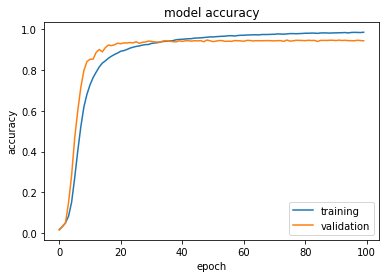

In [32]:
# plot accuracy and loss to evaluate the learning curve
plt.close('all')
plt.plot(H2.history['accuracy'])
plt.plot(H2.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training','validation'], loc='lower right')
plt.savefig('accuracy_step2') 
plt.show()


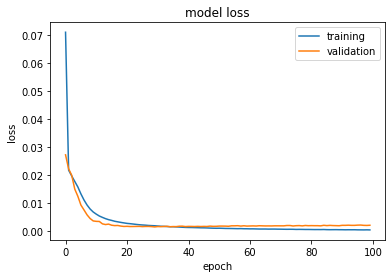

In [33]:
plt.close('all')
plt.plot(H2.history['loss'])
plt.plot(H2.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training','validation'], loc='upper right')
plt.savefig('loss_step2')
plt.show()